# 論文用のグラフ

In [1]:
#import
import sys
import math

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt import transmission as tr
from pyopt.util import save_pickle, load_pickle

# 1. 各種関数

### ANN定義

In [2]:
def data_shaping_ANN(input_signal, signal, sampling, tap, max_tap, n):
    x = np.zeros((len(input_signal) // n - (max_tap - 1), sampling * tap * 2), dtype=float)
    y = np.zeros((len(input_signal) // n - (max_tap - 1), 2), dtype=float)
    if sampling == 1:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                x[i, j * 2] = signal[n * (center - tap // 2 + j) + n // 2].real
                x[i, j * 2 + 1] = signal[n * (center - tap // 2 + j) + n // 2].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    else:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                for k, sample in enumerate([round(_ * n / sampling) for _ in range(sampling)]):
                    x[i, j * sampling * 2 + k * 2] = signal[n * (center - tap // 2 + j) + sample].real
                    x[i, j * sampling * 2 + k * 2 + 1] = signal[n * (center - tap // 2 + j) + sample].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    return x, y


class Dataset_ANN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)


class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
        if activation == 'ReLU':
            self.activation = F.relu
        elif activation == 'Sigmoid':
            self.activation = torch.sigmoid
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


def evm_score(y_pred, y_true):
    y_pred = y_pred[:, 0] + y_pred[:, 1] * 1j
    y_true = y_true[:, 0] + y_true[:, 1] * 1j
    symbol, index, inverse, counts = np.unique(y_true, return_index=True, return_inverse=True, return_counts=True)
    
    t_sum = 0
    for i in range(len(index)):
        t_sum += abs(y_true[index[i]])
    mean = t_sum / len(index)
    
    tmp = 0
    for i in range(len(y_pred)):
        tmp += abs(y_pred[i] - y_true[i]) ** 2
    if type(tmp) is np.float64:
        evm = np.sqrt(tmp / len(y_pred)) / mean
    else:
        evm = torch.sqrt(tmp / len(y_pred)) / mean
    return evm


def cal_evm_min(input_signal, output_signal):
    symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)

    t_sum = 0
    for i in range(len(index)):
        t_sum += abs(input_signal[index[i]])
    mean = t_sum / len(index)

    evm_min = 200
    i_min = 0
    for i in range(360):
        signal = output_signal * np.exp(1j * i * np.pi/180)
        tmp = 0
        for j in range(len(output_signal)):
            tmp += abs(signal[j] - input_signal[j]) ** 2# / abs(input_signal[j]) ** 2
        evm = np.sqrt(tmp / len(output_signal)) / mean * 100
        if evm < evm_min:
            evm_min = evm
            i_min = i
    return evm_min, i_min

### CVNN定義

In [3]:
def data_shaping_CVNN(input_signal, signal, sampling, tap, max_tap, n):
    x = np.zeros((len(input_signal) // n - (max_tap - 1), sampling * tap, 2), dtype=float)
    y = np.zeros((len(input_signal) // n - (max_tap - 1), 2), dtype=float)
    if sampling == 1:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                x[i, j * 2, 0] = signal[n * (center - tap // 2 + j) + n // 2].real
                x[i, j * 2, 1] = signal[n * (center - tap // 2 + j) + n // 2].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    else:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                for k, sample in enumerate([round(_ * n / sampling) for _ in range(sampling)]):
                    x[i, j * sampling + k, 0] = signal[n * (center - tap // 2 + j) + sample].real
                    x[i, j * sampling + k, 1] = signal[n * (center - tap // 2 + j) + sample].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    return x, y


class Dataset_CVNN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        
        x = torch.Tensor(x)
        y = torch.Tensor(y)
        
        x_i = x[:, 0]
        x_q = x[:, 1]
        y_i = y[0]
        y_q = y[1]
        return x_i, x_q, y_i, y_q


class CSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = torch.sigmoid(x_i), torch.sigmoid(x_q)
        return x_i, x_q


class CReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = F.relu(x_i), F.relu(x_q)
        return x_i, x_q


class modReLU(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.b = torch.tensor(-math.sqrt(1 / in_features), requires_grad=True)
    
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        norm = torch.sqrt(x_i ** 2 + x_q ** 2)
        
        out_i = F.relu(norm + self.b) * x_i / norm
        out_q = F.relu(norm + self.b) * x_q / norm
        return out_i, out_q


class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # 重み定義 Xavierの初期値
        k = 1 / in_features
        weight_i = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_i = nn.Parameter(weight_i)
        weight_q = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_q = nn.Parameter(weight_q)
        
        bias_i = torch.empty(out_features).uniform_(-k, k)
        self.bias_i = nn.Parameter(bias_i)
        bias_q = torch.empty(out_features).uniform_(-k, k)
        self.bias_q = nn.Parameter(bias_q)
        
    def forward(self, x_i, x_q):
        i = nn.functional.linear(x_i, self.weight_i) - nn.functional.linear(x_q, self.weight_q) + self.bias_i
        q = nn.functional.linear(x_i, self.weight_q) + nn.functional.linear(x_q, self.weight_i) + self.bias_q
        return i, q


class CVNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super().__init__()
        self.fc1 = ComplexLinear(input_dim, hidden_neuron)
        self.fc2 = ComplexLinear(hidden_neuron, output_dim)
        if activation == 'CSigmoid':
            self.activation = CSigmoid()
        elif activation == 'ZReLU':
            self.activation = ZReLU()
        elif activation == 'CReLU':
            self.activation = CReLU()
        elif activation == 'modReLU':
            self.activation = modReLU(input_dim)
    
    def forward(self, x_i, x_q):
        x_i, x_q = self.fc1(x_i, x_q)
        x_i, x_q = self.activation(x_i, x_q)
        x_i, x_q = self.fc2(x_i, x_q)
        return x_i, x_q

### データ読み込み

In [4]:
def load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax):
    if model_type == 'ANN':
        data_shaping = data_shaping_ANN
    elif model_type == 'CVNN':
        data_shaping = data_shaping_CVNN
    
    if signal_info['signal_type'] == 'prbs':
        return load_prbs(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'random':
        return load_random(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'image':
        return load_image(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)

In [5]:
def load_prbs(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    N = signal_info['N']
    itr = signal_info['itr']
    signal_condition = 'N=='+str(N)+'&itr=='+str(itr)
    signal_list = [N, itr] + [None] * 6
    
    # prbs.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'prbs.csv', index_col=0)
    
    # prbs.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if prbs.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [6]:
def load_random(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    seed = signal_info['seed']
    bit_num = signal_info['bit_num']
    signal_condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    signal_list = [None] * 2 + [seed, bit_num] + [None] * 4
    
    # random.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'random.csv', index_col=0)
    
    # random.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if random.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [7]:
def load_image(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    target_dir = signal_info['target_dir']
    step = signal_info['step']
    image_number = signal_info['image_number']
    image_number_split = image_number.split(', ')
    ebtb = signal_info['ebtb']
    signal_condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
    signal_list = [None] * 4 + [target_dir, step, image_number, ebtb]
    
    # image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'image.csv', index_col=0)
    
    x = None
    y = None
    for i in range(len(image_number_split)):
        # image.csvにおいて、指定した伝送条件を見たす行を抜き出す
        t_query = t_df.query('target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb) + '&' + trans_condition)
        
        # if image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
        if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
            print('指定された伝送条件の信号が存在しません')
            sys.exit()
        else:
            # 伝送信号を学習データに整形する
            sgnl = load_pickle(t_query.iloc[0]['data_path'])
            if lc:
                sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
                evm_min, i_min = cal_evm_min(sgnl.signal['x_0'][16::32], sgnl_distorted[16::32])
                sgnl_distorted = sgnl_distorted * np.exp(1j * i_min * np.pi/180)
                pr = sgnl.phase_rotation_theo(Lmax)
                sgnl_distorted = sgnl_distorted * np.exp(-1j * pr * np.pi/180)
            else:
                sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
            x_tmp, y_tmp = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
            if x is None:
                x = x_tmp
                y = y_tmp
            else:
                x = np.concatenate([x, x_tmp])
                y = np.concatenate([y, y_tmp])
    return x, y, signal_condition, signal_list

In [134]:
def prepare_input(model_info, signal_info, tap, PdBm):
    model_type = model_info['model_type']
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']
    
    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    
    # 指定した学習条件と伝送条件
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    x, y, _, _ = load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax)
    return x, y

### Model読み込み

In [9]:
def load_model(learn_condition, trans_condition, signal_condition, model_type, device, sampling, tap, neuron, epochs, activation, Lmax):
    l_df_dir = '../data/params/' + model_type + '.csv'
    l_df = pd.read_csv(l_df_dir, index_col=0)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(learn_condition + '&' + signal_condition + '&' + trans_condition + '&Lmax=='+str(Lmax))

    #if epochsを含む指定された条件を満たす結果がある: 何もしない
    if len(l_query) == 0 or l_query['epochs'].max() < epochs:
        print('指定された条件の学習結果は存在しません')
    else:
        index = l_query['epochs'].idxmax()
        if model_type == 'ANN':
            model = ANN(input_dim=sampling*tap*2, output_dim=2, hidden_neuron=neuron, activation=activation).to(device)
        elif model_type == 'CVNN':
            model = CVNN(input_dim=sampling*tap, output_dim=1, hidden_neuron=neuron, activation=activation).to(device)
        model.load_state_dict(torch.load(l_query['params_path'][index]))
    return model

In [135]:
def prepare_model(model_info, signal_info, tap, PdBm):
    device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
    # print('Device available now:', device)
    
    model_type = model_info['model_type']
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']
   
    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    
    # 指定した学習条件と伝送条件
    learn_condition = 'linear_compensation=='+str(lc)+'&sampling=='+str(sampling)+'&tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&epochs=='+str(epochs)+'&learning_rate=='+str(lr)+'&activation=="'+str(activation)+'"'
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    x, y, signal_condition, _ = load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax)
    if x is not None:
        model = load_model(learn_condition, trans_condition, signal_condition, model_type, device, sampling, tap, neuron, epochs, activation, Lmax)
        
        if model is not None:
            # 平均,標準偏差の計算
            mean = np.mean(x)
            std = np.std(x)
            
            return model, mean, std

### 予測

In [11]:
def predict_ANN(x, y, model_info, signal_info, tap, PdBm):
    model, mean, std = prepare_model(model_info, signal_info, tap, PdBm)
    dataset = Dataset_ANN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=model_info['batch_size'], shuffle=False)
    
    nnc = np.empty((0, 2), float)
    y = np.empty((0, 2), float)
    for x_bat, y_bat in dataloader:
        out = model(x_bat)
        nnc = np.append(nnc, out.detach().numpy().reshape(-1, 2) * std + mean, axis=0)
        y = np.append(y, (y_bat.detach().numpy().reshape(-1, 2) * std + mean).astype(np.int32), axis=0)
    return nnc, y

In [12]:
def predict_CVNN(x, y, model_info, signal_info, tap, PdBm):
    model, mean, std = prepare_model(model_info, signal_info, tap, PdBm)
    dataset = Dataset_CVNN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=model_info['batch_size'], shuffle=False)
    
    nnc_i = np.empty(0, float)
    nnc_q = np.empty(0, float)
    y_i = np.empty(0, float)
    y_q = np.empty(0, float)
    for x_bat_i, x_bat_q, y_bat_i, y_bat_q in dataloader:
        out_i, out_q = model(x_bat_i, x_bat_q)
        nnc_i = np.append(nnc_i, out_i.detach().numpy() * std + mean)
        nnc_q = np.append(nnc_q, out_q.detach().numpy() * std + mean)
        y_i = np.append(y_i, (y_bat_i.detach().numpy() * std + mean).astype(np.int32))
        y_q = np.append(y_q, (y_bat_q.detach().numpy() * std + mean).astype(np.int32))
    
    nnc = np.hstack([nnc_i.reshape(-1, 1), nnc_q.reshape(-1, 1)])
    y = np.hstack([y_i.reshape(-1, 1), y_q.reshape(-1, 1)])
    return nnc, y

### コンスタレーション

In [13]:
def display_constellation(nnc, y):
    evm = round(evm_score(nnc, y) * 100, 2)
    nnc = nnc[:, 0] + nnc[:, 1] * 1j
    y = y[:, 0] + y[:, 1] * 1j
    
    symbol, inverse, counts = np.unique(y, return_inverse=True, return_counts=True)
    cm = plt.get_cmap('rainbow', 16)
    boxdic = {
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1}
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(symbol)):
        ax.plot(nnc[y == symbol[i]].real, nnc[y == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    for i in range(len(symbol)):
        ax.plot(y[y == symbol[i]].real, y[y == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
    ax.text(-100000, 95000, 'EVM: ' + str(evm) + '%', color='black', fontsize=20, bbox=boxdic)
    ax.set_xlim((-110000, 110000))
    ax.set_ylim((-110000, 110000))
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

# 2. 可視化

## 2.0 matplotlibパラメータの指定

In [229]:
plt.rcParams["font.family"] = "Times New Roman" # フォント
plt.rcParams["mathtext.fontset"] = 'dejavuserif' # 数式フォント 'dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom'
plt.rcParams["mathtext.default"] = 'it' # 数式フォントをイタリックにする
plt.rcParams["font.size"] = 14 # フォントの大きさ
plt.rcParams["lines.markersize"] = 8 # マーカーの大きさ
plt.rcParams["lines.linewidth"] = 1.3 # 線の太さ 
plt.rcParams["xtick.direction"] = "in" # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in" # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.minor.visible"] = True # x軸補助目盛りの追加
plt.rcParams["ytick.minor.visible"] = True # y軸補助目盛りの追加
plt.rcParams["xtick.major.width"] = 1.0 # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0 # y軸主目盛り線の線幅
plt.rcParams["xtick.minor.width"] = 1.0 # x軸補助目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 1.0 # y軸補助目盛り線の線幅
plt.rcParams["xtick.major.size"] = 10 # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 10 # y軸主目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 5 # x軸補助目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 5 # y軸補助目盛り線の長さ
plt.rcParams['xtick.top'] = False # x軸の上部目盛り
plt.rcParams['ytick.right'] = False # y軸の右部目盛り
plt.rcParams["axes.linewidth"] = 1.3 # 囲みの太さ

## 2.1 グリッドサーチ

In [14]:
tap = 1
PdBm = 1

model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 0,
                          'epochs': 0,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

epoch = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
neuron = [10, 20, 40, 80, 160, 320, 640, 1280]
evms_grid = np.zeros((8, 10), dtype=float)
for i, n in enumerate(tqdm(neuron)):
    for j, e in enumerate(epoch):
        model_info['neuron'] = n
        model_info['epochs'] = e
        
        x, y = prepare_input(model_info, signal_info_input, tap, PdBm)
        nnc, y = predict_ANN(x, y, model_info, signal_info_model, tap, PdBm)
        evms_grid[i, j] = evm_score(nnc, y) * 100

In [16]:
evms_grid_df = pd.DataFrame(data=evms_grid, index=neuron, columns=epoch, dtype='float')

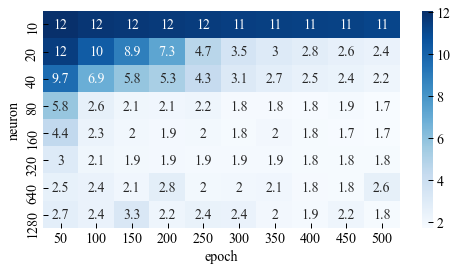

In [253]:
plt.rcParams["xtick.minor.visible"] = False # x軸補助目盛り無効化
plt.rcParams["ytick.minor.visible"] = False # y軸補助目盛り無効化
plt.rcParams["xtick.major.size"] = 5 # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 5 # y軸主目盛り線の長さ

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(evms_grid_df, cmap='Blues', annot=True, ax=ax)
ax.set_xlabel('epoch')
ax.set_ylabel('neuron')
ax.collections[0].colorbar;

plt.rcParams["xtick.minor.visible"] = True # x軸補助目盛り有効化
plt.rcParams["ytick.minor.visible"] = True # y軸補助目盛り有効化
plt.rcParams["xtick.major.size"] = 10 # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 10 # y軸主目盛り線の長さ

## 2.2 活性化関数

In [47]:
tap = 1
PdBm = 1
model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_test = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

In [48]:
epochs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
evms_activation = np.zeros((2, 10), dtype=float)
for i, epoch in enumerate(tqdm(epochs)):
    model_info['epochs'] = epoch
    
    model_info['model_type'] = 'ANN'
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    
    model_info['activation'] = 'Sigmoid'
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms_activation[0, i] = evm_score(nnc, y) * 100
    
    model_info['activation'] = 'ReLU'
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms_activation[1, i] = evm_score(nnc, y) * 100

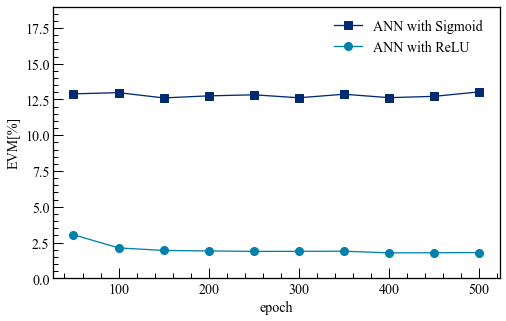

In [231]:
cm = plt.get_cmap('ocean', 10)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
shapes = ['-s', '-o', '-v', '-D']
colors = [[cm(4)[0], cm(4)[1], cm(4)[2]], [cm(6)[0], cm(6)[1], cm(6)[2]], [cm(7)[0], cm(7)[1], cm(7)[2]]]
legends = ['ANN with Sigmoid', 'ANN with ReLU']
for i in range(2):
    ax.plot(epochs, evms_activation[i], shapes[i], color=colors[i], label=legends[i])
plt.legend(bbox_to_anchor=(0.6, 1), loc='upper left', frameon=False)
plt.xlabel('epoch')
plt.ylabel('EVM[%]')
ax.set_ylim((0, 19));

## 2.3 サンプリングレート

In [50]:
model_info_ann = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

signal_info_model0 = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
signal_info_model1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}
signal_info_model2 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '0, 5, 6, 12, 17, 33, 35, 45, 52, 53', 'ebtb': True}

signal_info_test0 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_test1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10, 11, 13', 'ebtb': True}

In [51]:
tap = 1
PdBm = 1
samplings = [1, 2, 3, 4, 5]
evms_ann_t0 = np.zeros((3, 5), dtype=float)
for i, sampling in enumerate(tqdm(samplings)):
    model_info_ann['sampling'] = sampling
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_ann_t0[0, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model1, tap, PdBm)
    evms_ann_t0[1, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model2, tap, PdBm)
    evms_ann_t0[2, i] = evm_score(nnc, y) * 100

In [52]:
tap = 1
PdBm = 1
samplings = [1, 2, 3, 4, 5]
evms_ann_t1 = np.zeros((3, 5), dtype=float)
for i, sampling in enumerate(tqdm(samplings)):
    model_info_ann['sampling'] = sampling
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_ann_t1[0, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model1, tap, PdBm)
    evms_ann_t1[1, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model2, tap, PdBm)
    evms_ann_t1[2, i] = evm_score(nnc, y) * 100

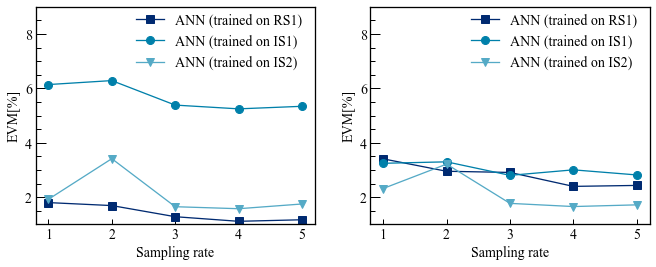

In [232]:
plt.rcParams["xtick.minor.visible"] = False # x軸補助目盛り無効化
plt.rcParams["xtick.major.size"] = 5 # x軸主目盛り線の長さ

cm = plt.get_cmap('ocean', 10)
fig = plt.figure(figsize=(11, 4))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
shapes = ['-s', '-o', '-v', '-D']
colors = [[cm(4)[0], cm(4)[1], cm(4)[2]], [cm(6)[0], cm(6)[1], cm(6)[2]], [cm(7)[0], cm(7)[1], cm(7)[2]]]
legends = ['ANN (trained on RS1)', 'ANN (trained on IS1)', 'ANN (trained on IS2)']
for i in range(3):
    ax0.plot(samplings, evms_ann_t0[i], shapes[i], color=colors[i], label=legends[i])
    ax1.plot(samplings, evms_ann_t1[i], shapes[i], color=colors[i], label=legends[i])
ax0.legend(bbox_to_anchor=(1, 1.03), loc='upper right', frameon=False)
ax0.set_xlabel('Sampling rate')
ax0.set_ylabel('EVM[%]')
ax1.legend(bbox_to_anchor=(1, 1.03), loc='upper right', frameon=False)
ax1.set_xlabel('Sampling rate')
ax1.set_ylabel('EVM[%]')
ax0.set_ylim((1, 9))
ax1.set_ylim((1, 9))

plt.rcParams["xtick.minor.visible"] = True # x軸補助目盛り有効化
plt.rcParams["xtick.major.size"] = 10 # x軸主目盛り線の長さ

## 2.4 ANNとDBPの比較

In [132]:
model_info_ann = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 5000}

signal_info_model0 = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_test0 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_test1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': True}
signal_info_test2 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': False}
signal_info_test3 = {'signal_type': 'image', 'target_dir': 'train', 'step': 10, 'image_number': '9', 'ebtb': True}
signal_info_test4 = {'signal_type': 'image', 'target_dir': 'train', 'step': 10, 'image_number': '9', 'ebtb': False}

base = 14.9

In [136]:
tap = 1
PdBm = 1
Ls = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
evms_L_t0 = np.zeros((4, 10), dtype=float)
dbp_evm0 = np.loadtxt('../data/dbp/result_PRBS_L.csv')
dbp_evm1 = np.loadtxt('../data/dbp/result_sa4_step30.csv')
for i, L in enumerate(tqdm(Ls)):
    evms_L_t0[0, i] = dbp_evm0[i]
    evms_L_t0[1, i] = dbp_evm1[i]
    
    model_info_ann['Lmax'] = L
    model_info_cvnn['Lmax'] = L
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t0[2, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t0[3, i] = evm_score(nnc, y) * 100

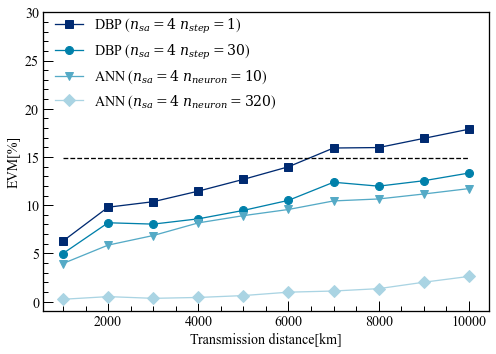

In [273]:
cm = plt.get_cmap('ocean', 10)
fig = plt.figure(figsize=(8, 5.5))
ax = fig.add_subplot(1, 1, 1)
shapes = ['-s', '-o', '-v', '-D']
colors = [[cm(4)[0], cm(4)[1], cm(4)[2]], [cm(6)[0], cm(6)[1], cm(6)[2]], [cm(7)[0], cm(7)[1], cm(7)[2]], [cm(8)[0], cm(8)[1], cm(8)[2]]]
legends = ['DBP ($n_{sa}=4$ $n_{step}=1$)', 'DBP ($n_{sa}=4$ $n_{step}=30$)', 'ANN ($n_{sa}=4$ $n_{neuron}=10$)', 'ANN ($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax.plot(Ls, evms_L_t0[i], shapes[i], color=colors[i], label=legends[i])
ax.plot(Ls, [base] * 10, '--', color='k')
plt.legend(bbox_to_anchor=(0, 1.03), loc='upper left', frameon=False)
plt.xlabel('Transmission distance[km]')
plt.ylabel('EVM[%]')
ax.set_ylim((-1, 30));

In [151]:
tap = 1
model_info_ann['Lmax'] = 5000
model_info_cvnn['Lmax'] = 5000
PdBms = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
evms_PdBm_t0 = np.zeros((4, 11), dtype=float)
dbp_evm0 = np.loadtxt('../data/dbp/result_PRBS_PdBm.csv')
dbp_evm1 = np.loadtxt('../data/dbp/result_sa4_step30_PdBm.csv')
for i, PdBm in enumerate(tqdm(PdBms)):
    evms_PdBm_t0[0, i] = dbp_evm0[i]
    evms_PdBm_t0[1, i] = dbp_evm1[i]
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_PdBm_t0[2, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_PdBm_t0[3, i] = evm_score(nnc, y) * 100

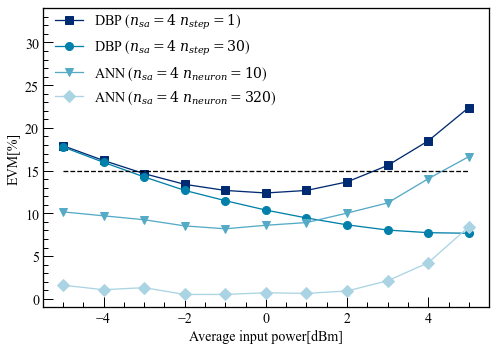

In [234]:
cm = plt.get_cmap('ocean', 10)
fig = plt.figure(figsize=(8, 5.5))
ax = fig.add_subplot(1, 1, 1)
shapes = ['-s', '-o', '-v', '-D']
colors = [[cm(4)[0], cm(4)[1], cm(4)[2]], [cm(6)[0], cm(6)[1], cm(6)[2]], [cm(7)[0], cm(7)[1], cm(7)[2]], [cm(8)[0], cm(8)[1], cm(8)[2]]]
legends = ['DBP ($n_{sa}=4$ $n_{step}=1$)', 'DBP ($n_{sa}=4$ $n_{step}=30$)', 'ANN ($n_{sa}=4$ $n_{neuron}=10$)', 'ANN ($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax.plot(PdBms, evms_PdBm_t0[i], shapes[i], color=colors[i], label=legends[i])
ax.plot(PdBms, [base] * 11, '--', color='k')
plt.legend(bbox_to_anchor=(0, 1.03), loc='upper left', frameon=False)
plt.xlabel('Average input power[dBm]')
plt.ylabel('EVM[%]')
ax.set_ylim((-1, 34));

## 2.5 計算量の比較

In [163]:
span = np.arange(1, 101, 10)
nsy = 10000

s = 1
nsa = 1
neuron = 320
ann_nsa1_neuron320 = ((2 * nsa * s * neuron + neuron * 2) * nsy + 4 * nsa * nsy * np.log2(nsa * nsy) + 4 * nsa * nsy) / nsy * np.ones_like(span)
nsa = 4
neuron = 10
ann_nsa4_neuron10 = ((2 * nsa * s * neuron + neuron * 2) * nsy + 4 * nsa * nsy * np.log2(nsa * nsy) + 4 * nsa * nsy) / nsy * np.ones_like(span)
neuron = 320
ann_nsa4_neuron320 = ((2 * nsa * s * neuron + neuron * 2) * nsy + 4 * nsa * nsy * np.log2(nsa * nsy) + 4 * nsa * nsy) / nsy * np.ones_like(span)

nsa = 2
step = 1
dbp = (10 * span * step * nsa * nsy + span * step * (4 * nsa * nsy * np.log2(nsa * nsy) + 4 * nsa * nsy)) / nsy

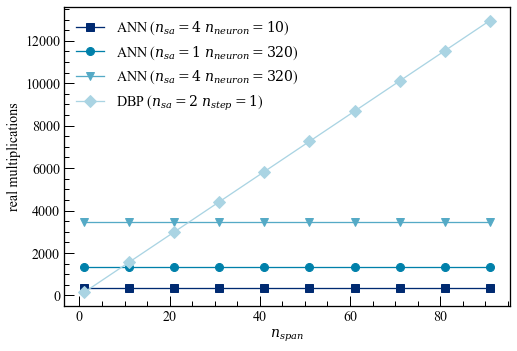

In [235]:
cm = plt.get_cmap('ocean', 10)
fig = plt.figure(figsize=(8, 5.5))
ax = fig.add_subplot(1, 1, 1)
shapes = ['-s', '-o', '-v', '-D']
colors = [[cm(4)[0], cm(4)[1], cm(4)[2]], [cm(6)[0], cm(6)[1], cm(6)[2]], [cm(7)[0], cm(7)[1], cm(7)[2]], [cm(8)[0], cm(8)[1], cm(8)[2]]]
ax.plot(span, ann_nsa4_neuron10, shapes[0], color=colors[0], label='ANN ($n_{sa}=4$ $n_{neuron}=10$)')
ax.plot(span, ann_nsa1_neuron320, shapes[1], color=colors[1], label='ANN ($n_{sa}=1$ $n_{neuron}=320$)')
ax.plot(span, ann_nsa4_neuron320, shapes[2], color=colors[2], label='ANN ($n_{sa}=4$ $n_{neuron}=320$)')
ax.plot(span, dbp, shapes[3], color=colors[3], label='DBP ($n_{sa}=2$ $n_{step}=1$)')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('$n_{span}$')
plt.ylabel('real multiplications');

## 2.6 グラフを一緒にする

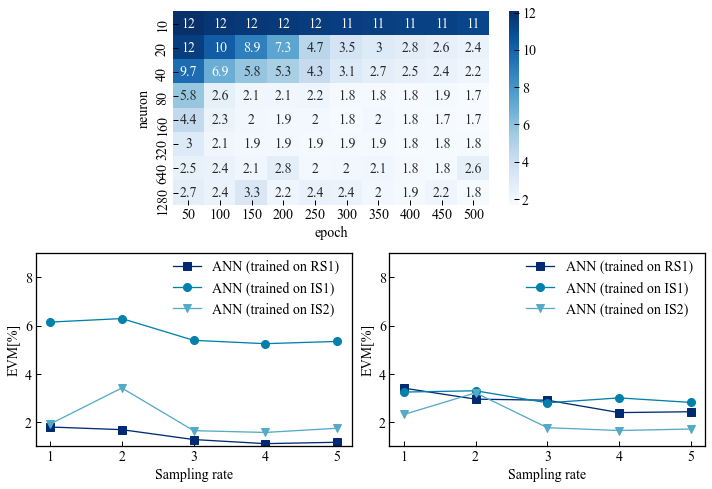

In [254]:
plt.rcParams["xtick.minor.visible"] = False # x軸補助目盛り無効化
plt.rcParams["ytick.minor.visible"] = False # y軸補助目盛り無効化
plt.rcParams["xtick.major.size"] = 5 # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 5 # y軸主目盛り線の長さ

cm = plt.get_cmap('ocean', 10)
fig = plt.figure(figsize=(12, 8))
ax0 = fig.add_subplot(2, 5, (2, 4))
ax1 = fig.add_subplot(2, 2, 3)
ax2 = fig.add_subplot(2, 2, 4)
shapes = ['-s', '-o', '-v', '-D']
colors = [[cm(4)[0], cm(4)[1], cm(4)[2]], [cm(6)[0], cm(6)[1], cm(6)[2]], [cm(7)[0], cm(7)[1], cm(7)[2]], [cm(8)[0], cm(8)[1], cm(8)[2]]]

sns.heatmap(evms_grid_df, cmap='Blues', annot=True, ax=ax0)
ax0.set_xlabel('epoch')
ax0.set_ylabel('neuron')
ax0.collections[0].colorbar;

legends = ['ANN (trained on RS1)', 'ANN (trained on IS1)', 'ANN (trained on IS2)']
for i in range(3):
    ax1.plot(samplings, evms_ann_t0[i], shapes[i], color=colors[i], label=legends[i])
    ax2.plot(samplings, evms_ann_t1[i], shapes[i], color=colors[i], label=legends[i])
ax1.legend(bbox_to_anchor=(1, 1.03), loc='upper right', frameon=False)
ax1.set_xlabel('Sampling rate')
ax1.set_ylabel('EVM[%]')
ax2.legend(bbox_to_anchor=(1, 1.03), loc='upper right', frameon=False)
ax2.set_xlabel('Sampling rate')
ax2.set_ylabel('EVM[%]')
ax1.set_ylim((1, 9))
ax2.set_ylim((1, 9))

plt.subplots_adjust(wspace=0.12, hspace=0.25)

plt.rcParams["xtick.minor.visible"] = True # x軸補助目盛り有効化
plt.rcParams["ytick.minor.visible"] = True # y軸補助目盛り有効化
plt.rcParams["xtick.major.size"] = 10 # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 10 # y軸主目盛り線の長さ

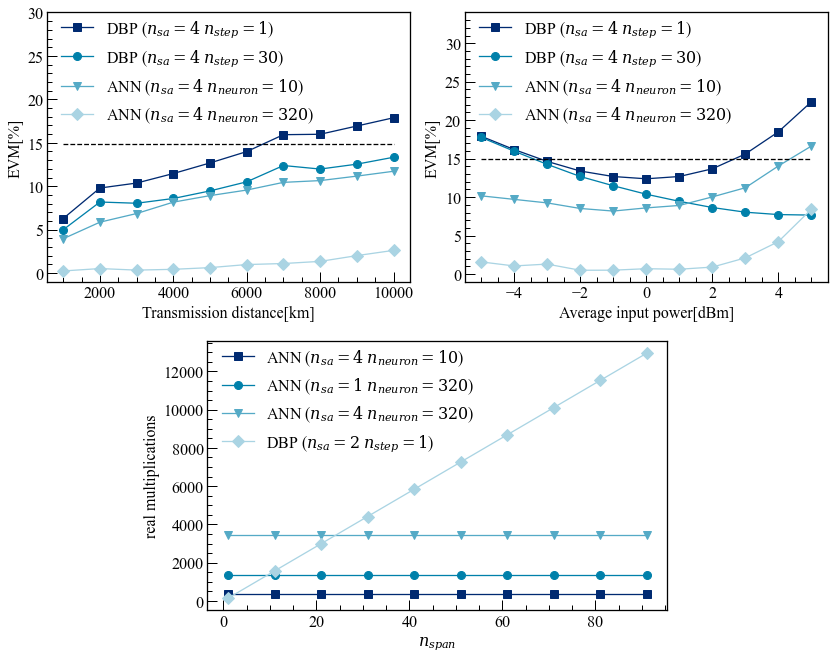

In [272]:
plt.rcParams["font.size"] = 16 # フォントの大きさ

cm = plt.get_cmap('ocean', 10)
fig = plt.figure(figsize=(14, 11))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 5, (7, 9))
shapes = ['-s', '-o', '-v', '-D']
colors = [[cm(4)[0], cm(4)[1], cm(4)[2]], [cm(6)[0], cm(6)[1], cm(6)[2]], [cm(7)[0], cm(7)[1], cm(7)[2]], [cm(8)[0], cm(8)[1], cm(8)[2]]]

legends = ['DBP ($n_{sa}=4$ $n_{step}=1$)', 'DBP ($n_{sa}=4$ $n_{step}=30$)', 'ANN ($n_{sa}=4$ $n_{neuron}=10$)', 'ANN ($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax0.plot(Ls, evms_L_t0[i], shapes[i], color=colors[i], label=legends[i])
ax0.plot(Ls, [base] * 10, '--', color='k')
ax0.legend(bbox_to_anchor=(0, 1.03), loc='upper left', frameon=False)
ax0.set_xlabel('Transmission distance[km]')
ax0.set_ylabel('EVM[%]')
ax0.set_ylim((-1, 30))

for i in range(4):
    ax1.plot(PdBms, evms_PdBm_t0[i], shapes[i], color=colors[i], label=legends[i])
ax1.plot(PdBms, [base] * 11, '--', color='k')
ax1.legend(bbox_to_anchor=(0, 1.03), loc='upper left', frameon=False)
ax1.set_xlabel('Average input power[dBm]')
ax1.set_ylabel('EVM[%]')
ax1.set_ylim((-1, 34))

ax2.plot(span, ann_nsa4_neuron10, shapes[0], color=colors[0], label='ANN ($n_{sa}=4$ $n_{neuron}=10$)')
ax2.plot(span, ann_nsa1_neuron320, shapes[1], color=colors[1], label='ANN ($n_{sa}=1$ $n_{neuron}=320$)')
ax2.plot(span, ann_nsa4_neuron320, shapes[2], color=colors[2], label='ANN ($n_{sa}=4$ $n_{neuron}=320$)')
ax2.plot(span, dbp, shapes[3], color=colors[3], label='DBP ($n_{sa}=2$ $n_{step}=1$)')
ax2.legend(bbox_to_anchor=(0, 1.03), loc='upper left', frameon=False)
ax2.set_xlabel('$n_{span}$')
ax2.set_ylabel('real multiplications')

plt.subplots_adjust(wspace=0.15, hspace=0.22)

plt.rcParams["font.size"] = 14 # フォントの大きさ